# Construction of JSON object Authors from INSPIRE-HEP
<img src="https://raw.githubusercontent.com/restrepo/inspire/master/img/authors.svg" width=700>

## Design of the object-oriented alghorithm
each object must be initialized with the relevant part of the JSON from the INSPIRE-HEP api, and must has a method to obtain the relevant part of the "author" object.

For example. The basic class must be `profile` and the input must be the JSON, `p`, from the profile API response
```
>>> au=profile(p)
>>> au.get_author()
```
`au` has the attributes according to the previous scheme

In [1]:
import pandas as pd
import sys
from IPython.display import JSON
import pickle

In [2]:
import json
import requests
import time
import copy
#https://towardsdatascience.com/do-not-use-if-else-for-validating-data-objects-in-python-anymore-17203e1d65fe
from cerberus import Validator
import pycountry

global timeout
timeout=5
global countries
countries=[x.name for x in pycountry.countries]

global _excluded_keys
_excluded_keys=['get_author','author','sample_profile','schema_profile','to_dict','to_json',
               'get_authors','db','sample_author', 'schema_author', 'sleep','profile',
                'sample_work', 'schema_work', 'work',
               'institutions_list', 'literature_size','not_collaboration','q', 'q_inst', 'size', 'size_inst', 'work_list',
               'cache','cacheco','institution_ids']

class empty_json:
    status_code=0
    def json(self):
        return {}

class profile:
    #Default behaviour: if key exists must be 'type'
    schema_profile={"name":{'type':'dict','required':True},
            "email_addresses":{'type':'list'},
            "positions":{'type':'list'},
            "ids":{'type':'list'},
            }        
    sample_profile={"advisors":[{"ids":[{"value":"INSPIRE-00133260",
                                    "schema":"INSPIRE ID"}],
                "name":"Valle, Jose W.F.",
                "hidden":False,
                "record":{"$ref":"https://inspirehep.net/api/authors/985058"},
                "degree_type":"phd","curated_relation":False},
               {"name":"Ponce, William A.","hidden":False,
                "degree_type":"master",
                "curated_relation":False}],
                "email_addresses":[{"value":"restrepo@udea.edu.co","current":True}],
    "positions":[{"rank":"SENIOR",
                  "hidden":False,
                  "record":{"$ref":"https://inspirehep.net/api/institutions/903906"},
                  "current":True,
                  "start_date":"2004",
                  "institution":"Antioquia U.",
                  "curated_relation":True},
                 {"rank":"PHD",
                  "hidden":False,
                  "record":{"$ref":"https://inspirehep.net/api/institutions/907907"},
                  "current":False,
                  "end_date":"2001","start_date":"1997",
                  "institution":"Valencia U., IFIC","curated_relation":True}],
    "ids":[{"value":"D.Restrepo.1","schema":"INSPIRE BAI"},
           {"value":"INSPIRE-00119748","schema":"INSPIRE ID"},
           {"value":"0000-0001-6455-5564","schema":"ORCID"},
           {"value":"diego-restrepo-209b7927","schema":"LINKEDIN"}],
    "name":{"value":"Restrepo Quintero, Diego Alejandro",
            "preferred_name":"Diego Restrepo"},
    "stub":False,
    "urls":[{"value":"http://gfif.udea.edu.co"},
            {"value":"https://scholar.google.com/citations?user=1sKULCoAAAAJ"},
            {"value":"https://www.researchgate.net/profile/Diego_Restrepo2"}],
    "status":"active",
    "$schema":"https://inspirehep.net/schemas/records/authors.json",
    "deleted":False,
    "control_number":991924,
    "legacy_version":"20210323213044.0",
    "arxiv_categories":["hep-ph"],
    "legacy_creation_date":"1999-08-23"}
    def __init__(self,p):
        if p:
            v=Validator(self.schema_profile,allow_unknown=True)
            if not v.validate(p):
                raise Exception(f'''
                    Input is not an INSPIRE-HEP profile dictionary:
                    {v.errors}                    
                    See `self.sample_profile`'''
                               )
        self.profile=p
            
    def get_author(self):
        '''
        Select:
        * current position
        * non-INSPIRE ids
        * name
        * control_number
        * arxiv_categories
        '''        
        if not hasattr(self,'profile'):
            return {}
        p=self.profile
        self.name=p.get('name')
        self.positions=p.get('positions')
        self.email_addresses=p.get('email_addresses')
        self.ids=p.get('ids')
        
        return self
    def to_dict(self):
        l=[]
        for x in dir(self):
            if x.find('__')==-1 and x not in _excluded_keys:
                l.append((x,eval( f'self.{x}')) )
        return dict(l)
        #return dict( [(x,eval( f'self.{x}')) for x in dir(self) 
        #  if x.find('__')==-1 and x not in _excluded_keys] )
    
class author(profile):
    sleep=0.4
    #`ids → [{"schema": "INSPIRE BAI"}]` required for author_id
    #`affiliations → [{...}] required for institution_id
    schema_author={"ids": {'type':'list',
                           'schema':{'type':'dict',
                                     'schema':{'schema':{'type':'string'},
                                               'value': {'type':'string'}
                                              }
                                    }
                          }, 
            "record":{'type':'dict'}, 
            "full_name": {'type':'string'}, 
            "affiliations":{'type':'list',
                           'schema':{'type':'dict','required':True}}
           }
    sample_author={"ids":[{"value": "D.Restrepo.1", 
                            "schema": "INSPIRE BAI"}
                          ], 
                   "uuid": "300c9b2c-15b0-4937-ad36-8ccff33fd09d", 
                   "emails": ["restrepo@udea.edu.co"], 
                   "record": {"$ref": "https://inspirehep.net/api/authors/991924"}, 
                   "full_name": "Restrepo, Diego", 
                   "affiliations": [{"value": "Antioquia U.", 
                                     "record": {"$ref": "https://inspirehep.net/api/institutions/903906"}},
                                   {"value":"Campinas State U.",
                                    "record":{"$ref":"https://inspirehep.net/api/institutions/902714"}}], 
                   "signature_block": "RASTRAPd", 
                   "raw_affiliations": [{"value": "Instituto de Física, Universidad de Antioquia, Calle 70 No 52-21, Medellín, Colombia"}, 
                                        {"value": "Instituto de Física Gleb Wataghin, UNICAMP, 13083-859, Campinas, SP, Brazil"}]}
    def __init__(self,a,db=[]):
        self.author=a
        self.db=db
        if a:
            v=Validator(self.schema_author,allow_unknown=True)
            if not v.validate(a):
                raise Exception(f'''
                    Input is not an INSPIRE-HEP author dictionary:
                    {v.errors}
                    See `self.sample_author`''')
        #if not hasattr(self,'cache'):
        #    self.cache={}
        #if not hasattr(self,'cachecho'):
        #    self.cacheco={}                        
        #super(author, self).__init__(p)
    def get_authors(self):
        #TODO: Check previous analysis for more metadata
        #use requests
        a=self.author
        r=empty_json()
        self.full_name=a.get('full_name')
        try:
            self.author_id=[i for i  in a.get('ids') if i.get('schema')=='INSPIRE BAI'
                  ][0].get('value')
        except:
            self.author_id=None

        #a.get('affiliations') is not always there
        try:
            affiliations=[dict([(k,d.get(k)) for k in d if k in ['value','record']]) 
                               for d in a.get('affiliations') ]
        except TypeError:
            affiliations=[]
            
        #Profile
        try:
            url=a.get('record').get("$ref")
        except AttributeError:
            url=''
        if url and isinstance(url,str):
            self.profile_id=url.split('/')[-1]
            r=empty_json()
            try:
                r=requests.get(url,timeout=timeout)
                time.sleep(self.sleep)
            except:
                r.status_code=-1
        if r.status_code==200:
            p=r.json().get('metadata')
        else:
            p={}#{'status_code':r.status_code}
            #return self.db #author without affilitions are not considered
            
        #We assume that the affilition is defined at least for
        #one of the authors of the paper
        #Authos without affiliations to get their institution are not considered
        super(author, self).__init__(p)             
        d=super(author, self).get_author() #→ self.profile
        if self.author_id is None:
            try:
                self.author_id=[i for i  in self.profile.get('ids') if i.get('schema')=='INSPIRE BAI'
                  ][0].get('value')
            except:
                self.author_id=None            
            
        
        #self.to_dict=super(author, self).to_dict
        ll=[x for x in self.db if hasattr(x,'author_id') and hasattr(x,'institution_id')]
        #self.db[i] affiliation not in affiliation are not touched
        self.institution=''
        self.institution_id=None
        self.institution_ids=[]
        for aff in affiliations:
            #We assumme that aff have at least the institution infomation
            self.institution=aff.get('value')
            if not self.institution:
                self.institution_id=None
                self.country=None
                continue
            try:
                aff_url=aff.get('record').get('$ref')            
                self.institution_id=aff_url.split('/')[-1]
                self.institution_ids.append(self.institution_id)
                #self.cache[self.institution]=self.institution_id
            except AttributeError:
                self.institution_id=None#self.cache.get(self.institution) #None if not key
                aff_url=None
            
            #if self.cacheco.get(self.institution):
            #    self.country=self.cacheco.get(self.institution)
            self.country=None
            if aff_url:
                rr=empty_json()
                try:
                    rr=requests.get(aff_url,timeout=timeout)
                    time.sleep(self.sleep)
                except:
                    rr.status_code=-1
                if rr.status_code==200:
                    try:
                        self.country=rr.json().get('metadata').get('addresses')[0].get('country')
                        #if self.country:
                        #    self.cacheco[self.institution]=self.country
                    except:
                        self.country=None
            else:
                self.country=None
                
            
            filtered_db=[x for x in ll if x.author_id==self.author_id 
                         and x.institution_id==self.institution_id]
            if filtered_db:
                au=filtered_db[0] #must be unique!
            else: #aff not in self.db → New affiliation
                ai=copy.copy(self)#deepcopy(self)
                self.db.append(ai)
                del ai #be sure that ai will not be modified
        return self.db
    def to_json(self):
        return [d.to_dict() for d in self.db]
        
class work(author):
    schema_work={'citation_count':{'type':'integer'},
            'control_number':{'type':'integer','required':True},
            'primary_arxiv_category':{'type':'list'},
            'preprint_data':{'type':'string'},
            'legacy_creation_date':{'type':'string'}
            }
    def __init__(self,w,db=[]):
        self.sample_work={'citation_count': 0,
                          'control_number':2080612,
                          'publication_info':[
                                              {'year':2022,
                                              'journal_record': {'$ref': 'https://inspirehep.net/api/journals/1613946'}
                                              }
                                             ],
                          'primary_arxiv_category':['hep-ph'],
                          'authors':[self.sample_author]#publication_info,preprint_date,legacy_creation_date
                                }
        if w:
            v=Validator(self.schema_work,allow_unknown=True)
            if not v.validate(w):
                raise Exception(f'''
                    Input is not an INSPIRE-HEP work dictionary:
                    {v.errors}
                    See `self.sample_work`''')
        
        self.db=db
        self.work=w
    def get_authors(self):
        '''
        l: list of author objects
        '''
        l=self.work
        print(l.get('control_number'),end='\r')
        #TODO: Check previous analysis for more metadata
        primary_arxiv_category=l.get('primary_arxiv_category')
        if not primary_arxiv_category:
            try:
                primary_arxiv_category=l.get('arxiv_eprints')[0].get('categories')
            except TypeError:
                primary_arxiv_category=[]
        #if not primary_arxiv_category:
        #    primary_arxiv_category=[]
        try:
            journal_id=l.get('publication_info')[0].get('journal_record'
                                    ).get('$ref').split('/')[-1]
        except:
            journal_id='None'

        try:
            year=str(l.get('publication_info')[0].get('year')) #scheme validate
        except TypeError:
            year=0
        if not year:
            try:
                year=l.get('preprint_date').split('-')[0]
            except:
                year=0
        if not year:
            try:
                year=l.get('legacy_creation_date').split('-')[0]
            except:
                year=0
        if not year:
                year='0000'
        #'inst_id':aff_id
        paper={'recid':l.get('control_number'),'year':year,
               'citation_count':l.get('citation_count'),
               'primary_arxiv_category':primary_arxiv_category,
               'journal_id':journal_id}
        #In update
        #'primary_arxiv_category':primary_arxiv_category
        #super(work, self).__init__(w.get('authors')[0])
               
        aus=l.get('authors')
        for a in aus: #same self.author_id but several institute_ids for several affiliations
            super(work, self).__init__(a,self.db)
            super(work, self).get_authors() #add and replace self attributes → author*..., institution*..
            paper['author_id']=self.author_id
            #Each d object keeps its RAM memory space independent of reasignation list from db to adb
            adb=[d for d in self.db if d.author_id==self.author_id]

            papers=[]
            for d in adb:
                if hasattr(d,'papers'):
                    papers=d.papers
                    break #found papers for self.author_id
            for d in adb:
                d.papers=papers #reatach papers if already have
                if not self.institution_ids:
                    self.institution_ids.append(None)
                for iid in self.institution_ids: #creates a paper per affiliation
                    paper['instituion_id']=iid
                    if paper not in d.papers:
                        #detach from RAM!
                        cppaper=copy.copy(paper)
                        d.papers.append(cppaper)
                        del cppaper
            #break                
        return self.db     

class literature(work):
    def __init__(self,q,db=[],size=25):
        self.q=q
        self.db=db
        self.size=size
        print(f'*** {len(self.db)}***')
    def get_authors(self):
        NEXT=True
        i=0
        while NEXT:
            if i==0:
                url=f'https://inspirehep.net/api/literature?size={self.size}&page=1&q={self.q}'
            r=empty_json()
            try:
                r=requests.get(url,timeout=timeout)
                time.sleep(self.sleep)
            except:
                r.status_code=-1
            if r.status_code!=200:
                print(f'WARNING → bad request for q={self.q}')
                return self.db
            try:
                self.work_list=r.json().get('hits').get('hits')
            except:
                print(f'WARNING → bad request for q={self.q}')
                return self.db
            #We assume here that r.json().get('links') exists
            if r.json().get('links').get('next'):
                url=r.json().get('links').get('next')
            else:
                NEXT=False
            #An exisiting db is updated against this query. Check old recids:
            t=[[p.get('recid') for p in d.papers if isinstance(p.get('recid'),int)] for d in self.db]
            tt=list(set([item for sublist in t for item in sublist if item is not None]))
            for l in self.work_list:
                w=l.get('metadata')
                if w.get('control_number') in tt:
                    print(f'WARNING: {w.get("control_number")} already analized',end='\r')
                    continue
                #else:
                #    print(f'new → {w.get("control_number")}')
                    
                super(literature, self).__init__(w,self.db)
                super(literature, self).get_authors() #add and replace self attributes → author*..., institution*..
            #EMERGENCY EXIT: We assume here that r.json().get('total') exists
            if i>r.json().get('hits').get('total')//self.size+1:
                NEXT=False
            i+=1
        return self.db
    
class institutions(literature):
    def __init__(self,q,db=[],not_collaboration=True,size=25,literature_size=25):
        self.q_inst=q
        self.db=db
        self.size_inst=size
        self.literature_size=literature_size
        self.not_collaboration=not_collaboration
    def get_authors(self):
        if self.not_collaboration:
            ac='ac 1->10'
        else:
            ac=''
        NEXT=True
        i=0
        while NEXT:
            if i==0:
                #TODO: add author number restriction
                url=f'https://inspirehep.net/api/institutions/?q={self.q_inst}&size={self.size_inst}&page=1'
            r=empty_json()
            try:
                r=requests.get(url,timeout=timeout)
                time.sleep(self.sleep)        
            except:
                r.status_code=-1
            if r.status_code!=200:
                print(f'WARNING → bad request for q={self.q_inst}')
                return self.db
            try:
                self.institutions_list=r.json().get('hits').get('hits')
            except:
                print(f'WARNING → bad request for q={self.q_inst}')
                return self.db
            #We assume from here that r.json() is just OK
            links=r.json().get('links')
            total=r.json().get('hits').get('total')
            COUNTRY=False
            if self.q_inst in countries:
                COUNTRY=True
            #get aff_legacy name and aff realy belongs to country: https://stackoverflow.com/a/46249796
            #fix q=aff_legacy
            for ist in self.institutions_list:
                if COUNTRY:
                    try:
                        country=ist.get('metadata').get('addresses')[0].get('country')
                    except:
                        country=''
                    if self.q_inst!=country:
                        print(f'WARNING: affiliation is in {country}, not in {self.q_inst}')
                        continue
                    else:
                        self.country=country #if the extraction of affiliation fails
                aff=ist.get('metadata').get('control_number')#('legacy_ICN')
                #TODO: check old code for encoding
                q_aff=f'affid:{aff}'
                if ac:
                    q_aff=f'{q_aff} and {ac}'
                print(q_aff,'\r')                                    
                #q_aff=requests.utils.quote(q_aff)
                super(institutions, self).__init__(q_aff,self.db,size=self.literature_size) #WARNING → self.q and self.size produced
                super(institutions, self).get_authors() #add and replace self attributes → author*..., institution*..
            #We assume here that r.json().get('links') exists
            if links.get('next'):
                url=links.get('next')
            else:
                NEXT=False
            #EMERGENCY EXIT: We assume here that r.json().get('total') exists
            if i > total//self.size_inst+1:
                NEXT=False
            i+=1
            print(f'page: {i} of {total-1} → {url}')            
        return self.db 

## Tests

In [4]:
au=profile({})
p=au.sample_profile
au=profile(p)
P=au.get_author()
assert P.name.get('value') =='Restrepo Quintero, Diego Alejandro'
assert au.name.get('value')=='Restrepo Quintero, Diego Alejandro'
assert au.to_dict().get('name').get('value')=='Restrepo Quintero, Diego Alejandro'

In [5]:
AU=author({})
a=AU.sample_author
AU=author(a,db=[])
db=AU.get_authors()
au=db[0]
assert au.profile_id=='991924'
assert au.author_id =='D.Restrepo.1'
assert au.email_addresses[0]['value']=='restrepo@udea.edu.co'
assert au.full_name=='Restrepo, Diego'
assert [ d.get('value') for d in au.ids if d.get('schema')=='ORCID'
   ][0]=='0000-0001-6455-5564'
assert au.institution=='Antioquia U.'
assert au.institution_id=='903906'
assert au.name.get('value')=='Restrepo Quintero, Diego Alejandro'
assert au.positions[0].get('rank')=='SENIOR'
assert db[1].institution=='Campinas State U.'
assert db[1].profile_id==db[0].profile_id
#add a third value to db
new_au=copy.copy(db[0])
new_au.profile_id='991925'
db.append(new_au)
del new_au
AU=author(a,db) #TODO →Check update scenarios
ll=AU.get_authors()
assert ll[2].profile_id=='991925'
assert AU.to_json()[1].get('institution')=='Campinas State U.'
assert AU.to_json()[0].get('profile_id')==AU.to_json()[1].get('profile_id')

In [6]:
W=work({})
w=W.sample_work
W=work(w)
db=W.get_authors()
assert db[1].papers[0]['recid']==2080612
W=work(w,db)
db=W.get_authors()
assert len(db)==2
assert W.to_json()[1].get('papers')[0]['recid']==2080612
assert W.to_json()[1].get('papers')[0]['journal_id']=='1613946'

In [7]:
f=open('data/work.json','r')
w=json.load(f)
f.close()
W=work(w,[])
db=W.get_authors()
assert len(db[0].papers)==1 and db[0].papers[0].get('author_id')=='N.Bernal.1'
assert len(db[1].papers)==1 and db[1].papers[0].get('author_id')=='D.Restrepo.1'
assert len(W.to_json()[0].get('papers'))==1 and W.to_json()[0].get('papers')[0].get('author_id')=='N.Bernal.1'
assert len(W.to_json()[1].get('papers'))==1 and W.to_json()[1].get('papers')[0].get('author_id')=='D.Restrepo.1'

In [8]:
#db is update only if necessary
W=work(w,db)
db=W.get_authors()
assert len(db[0].papers)==1 and db[0].papers[0].get('author_id')=='N.Bernal.1'
assert len(db[1].papers)==1 and db[1].papers[0].get('author_id')=='D.Restrepo.1'
assert len(W.to_json()[0].get('papers'))==1 and W.to_json()[0].get('papers')[0].get('author_id')=='N.Bernal.1'
assert len(W.to_json()[1].get('papers'))==1 and W.to_json()[1].get('papers')[0].get('author_id')=='D.Restrepo.1'

In [9]:
#db only updated with new papers
w=W.sample_work
for i in range(2):
    W=work(w,db)
    db=W.get_authors()
    assert len(db[1].papers)==3
    assert len( W.to_json()[1].get('papers') )==3

test with author without profile

In [10]:
a={"full_name":"Terezón, Brisa",
   "affiliations":[{"record":{"$ref":"https://inspirehep.net/api/institutions/907440"},
                    "value":"El Salvador U."}],
   "ids":[{"schema":"INSPIRE BAI","value":"B.Terezon.1"}]
  }
A=author(a)
A.get_authors()
assert A.db[0].author_id=='B.Terezon.1'
assert A.db[0].institution_id=='907440'
assert A.to_json()[0].get('author_id')=='B.Terezon.1'
assert A.to_json()[0].get('institution_id')=='907440'

### Test large author:

In [26]:
TEST=False #Very slow test
if TEST:
    db=[]
    U=literature('ea L.Tomio.1 and ac 1->10',db,size=250)
    db=U.get_authors()

    kk=[d for d in  U.db if d.author_id=='L.Tomio.1'][0]
    papers=kk.papers

    assert len([p for p in papers if p.get('recid')==1966593 and 
                                       p.get('author_id')=='L.Tomio.1'])==1

### Test large institution

In [32]:
TEST=False
if TEST:
    db=[]
    U=literature('affid:907598 and ac 1->10',db,size=250)
    db=U.get_authors()

    db=pd.DataFrame( U.to_json() )

    db['N']=db.papers.apply(len)

    db=db.sort_values('N',ascending=False).iloc[1]

    pd.DataFrame(db.papers).drop_duplicates(subset=['recid']).shape

    dp=pd.DataFrame(db.papers)
    #dp[dp.recid==1966593]
    dp.recid.value_counts()

## Latin America Countries

In [3]:
LA_countries=['Brazil', 'Mexico', 'Argentina','Chile', 'Colombia','Bolivia','Cuba', #5
              'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras', #10
               'Nicaragua', 'Panama', 'Paraguay', 'Peru', #15
              'Dominican Republic','Uruguay','Venezuela']

In [4]:
db=[]

In [3]:
f=open('inspire_LA.pickle','rb')
db=pickle.load(f)
f.close()

In [4]:
old_len=len(db)
old_len

57588

In [5]:
del db

In [ ]:
for c in LA_countries[::-1]:
    print('='*20,c,'='*20)
    C=institutions(c,db,size=250,literature_size=250)
    db=C.get_authors()
    f=open('inspire_LA.pickle','wb')
    pickle.dump(db,f)
    f.close()
    db_json=C.to_json()
    f=open('inspire_LA.json','w')
    json.dump(db_json,f)
    f.close()

In [ ]:
if True:    
    f=open('inspire_LA.pickle','wb')
    pickle.dump(db,f)
    f.close()
    db_json=C.to_json()
    f=open('inspire_LA.json','w')
    json.dump(db_json,f)
    f.close()

## Example

In [17]:
import pandas as pd

In [18]:
db=pd.read_json('inspire_LA.json',dtype={'institution_id':int})

In [20]:
db=db[db['country']=='Venezuela'].reset_index(drop=True)

In [21]:
dp=pd.DataFrame( db.papers.apply(pd.Series).stack().to_list() ).drop_duplicates(subset='recid').reset_index(drop=True)

In [32]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:>

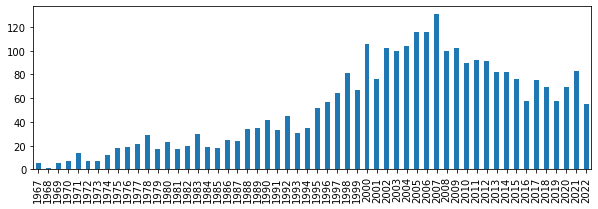

In [36]:
plt.figure(figsize=(10,3))
dp[dp['year']!='None']['year'].value_counts().sort_index().plot(kind='bar')

In [38]:
def hIndex(citations):
    """
    https://github.com/kamyu104/LeetCode/blob/master/Python/h-index.py
    :type citations: List[int]
    :rtype: int
    
    # Given an array of citations (each citation is a non-negative integer)
    # of a researcher, write a function to compute the researcher's h-index.
    #
    # According to the definition of h-index on Wikipedia: 
    # "A scientist has index h if h of his/her N papers have
    # at least h citations each, and the other N − h papers have
    # no more than h citations each."
    #
    # For example, given citations = [3, 0, 6, 1, 5], 
    # which means the researcher has 5 papers in total
    # and each of them had received 3, 0, 6, 1, 5 citations respectively. 
    # Since the researcher has 3 papers with at least 3 citations each and 
    # the remaining two with no more than 3 citations each, his h-index is 3.
    #
    # Note: If there are several possible values for h, the maximum one is taken as the h-index.
    """
    import builtins
    sum=builtins.sum
    return sum(x >= i + 1 for i, x in enumerate(sorted(  list(citations), reverse=True)))

h-Index

In [41]:
hIndex(dp.citation_count)

104

In [43]:
import time

h5-Index

In [77]:
hIndex( dp[dp.year.apply(lambda y: eval(y) if y else 0
            ).apply(lambda y: y>time.localtime().tm_year-6 and
                               y<time.localtime().tm_year-1)
           ].citation_count)

32